<a href="https://colab.research.google.com/github/MiladQolami/Neural-Data-Analysis/blob/main/SpikingVariablity/SpikingVariablity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⭕ spiking variablity

---











#### Each time we present an indentical sensory stimulus to a subject, for example an animal and record the spiking activity, neurons respond differently. This variablity is of great importance when it comes to study of infomation coding either by a single neuron or a population of neurons. The reason is that the amount of information that can be encoded by a neuron is directly related to variance of its response . As an extreme case, imagine that the response variability of a neuron is 0 which means no matter what kind of stimulus is presented, the response would be the same, so no information can be coded in this case. 

#### Possible source of this variablity might be current state of neuronal network, intrinsic neuroanl noise or properties or the neuron itself. In any case measuring spiking variablity can be an improtant setp toward understanding encoding infromation by neurons. 

#### We can take many different approaches to measure variability of spiking activity. In this notebook we overview some of these approaches including spike count correlation (SCC) also known as noise correlation, variability of inter spike interval (ISI) and trial to trial variability.


### Dataset:
The data for this notebook comes from recording form mouse brain by a Neuropixel probes while doing a visual discremination task.
For more information see the paper [Steinmetz et.all, 2019](https://www.nature.com/articles/s41586-019-1787-x).

Here we pick spiking response of some units in the primary visual cortex.


In [1]:
# @markdown Import libraries

# Import pachages
import os, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
%matplotlib inline

plt.rcParams['figure.figsize'] = [20,5]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
# @title Data loading
all_data = np.array([])
for j in range(len(fname)):
  all_data = np.hstack((all_data,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
data = all_data[11] # We only choose session 11 for our analysis, according to author this session has several units in visual cortex

The whole dataset contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. We have picked just one session (session 11) and stored it in `data`, which is a dictionary with several fields. You can find them using the method `.keys()`. Some of them are as below:


* `data['spks']`: neurons by trials by time bins.    
* `data['brain_area']`: brain area for each neuron recorded. 
* `data['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `data['contrast_left']`: contrast level for left stimulus. 
* `data['gocue']`: when the go cue sound was played. 
* `data['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `data['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `data['feedback_time']`: when feedback was provided. 
* `data['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `data['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `data['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.

* `data['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  



#### **First of all data exploration and visualization**

In [ ]:
# Run the codes line by line
data.keys()         # All fields

all_brain_areas = data['brain_area']
type(all_brain_areas)                     # What is iside each field
all_brain_areas.shape                     # What is the shape of it

all_spikes = data['spks']
type(all_spikes)
all_spikes.shape


(698, 340, 250)

<ipython-input-5-3e3d0bc43410>:4: DeprecationWarning: This function is deprecated. Please call randint(1, 698 + 1) instead
  random_neuron = np.random.random_integers(neuron_n)     # Pick a random neuron


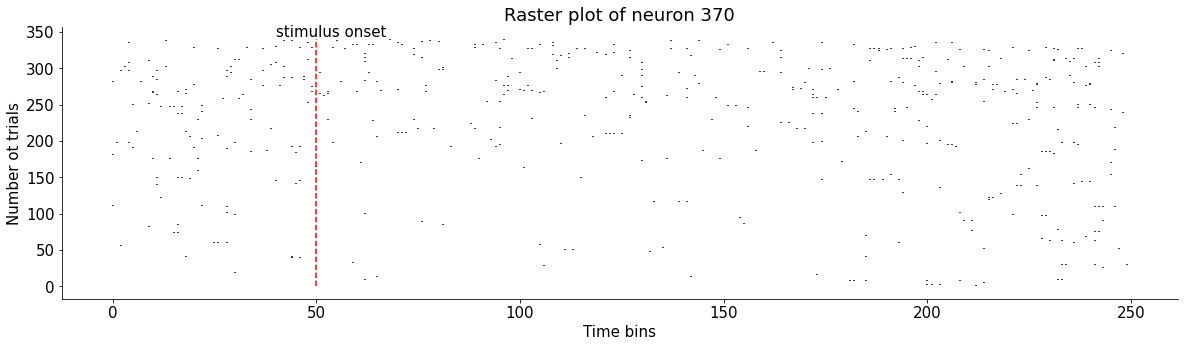

In [ ]:
# @markdown Run this cell several times to see raster plot of different neuron in this session
# Raster plot of random neuron 
neuron_n = data['spks'].shape[0]        # Number of neuron in this plot
random_neuron = np.random.random_integers(neuron_n)     # Pick a random neuron
fig, ax = plt.subplots()
for trial_i in range(data['spks'][random_neuron].shape[0]):
  ax.vlines(np.argwhere(data['spks'][random_neuron][trial_i,:]),trial_i,trial_i +1)
ax.vlines(50,0,data['spks'][random_neuron].shape[0],linestyles='dashed',color = 'red')
ax.set(xlabel = 'Time bins', ylabel = "Number ot trials",title=f'Raster plot of neuron {random_neuron}')
plt.text(50 - 10,trial_i+5,'stimulus onset')
plt.show()


In [ ]:
visual_cortex = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]  # visual cortex
hippocampus =  ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal

In [ ]:
idx_vis = np.isin(data['brain_area'],visual_cortex)   # Indices for neurons(units) in visual cortex regions
neuron_vis = idx_vis.sum()                            # How many visual neuron we have in this particular session
spikes_vis = data['spks'][idx_vis]                    # All spikes of visual neurns
trial_n = data['spks'].shape[1]
time_bins = np.arange(0,250,1)

#### Population response of visual neurons

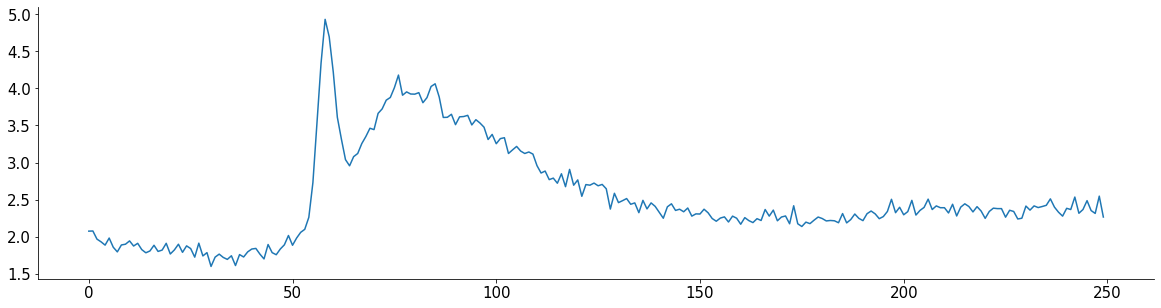

In [ ]:
average_resp_vis = np.mean(np.mean(spikes_vis,0),0) * 100

fig,ax = plt.subplots()
ax.plot(time_bins,average_resp_vis)
plt.show()

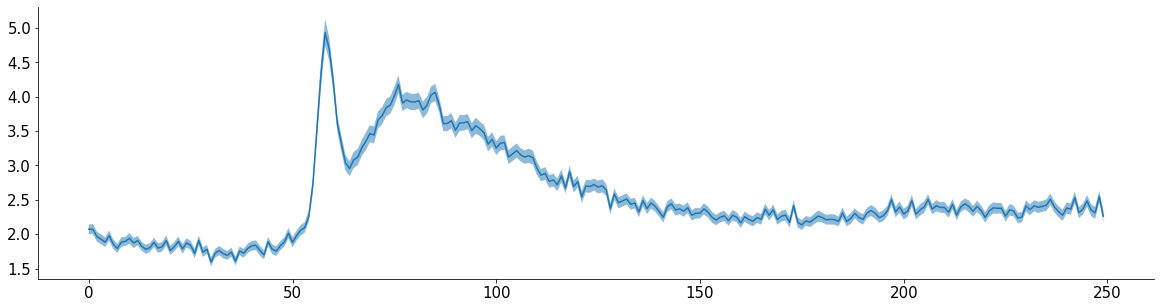

In [ ]:
# @markdown Add standard error of mean 
SEM_resp_vis = np.std(np.mean(spikes_vis,0) * 100,0) / np.sqrt(trial_n)
fig,ax = plt.subplots()
ax.plot(time_bins,average_resp_vis)
ax.fill_between(time_bins,average_resp_vis - SEM_resp_vis, average_resp_vis + SEM_resp_vis,alpha = .5)
plt.show()

### **Spike Count Correlation or Noise Correlation**

SCC is a measure of shared variability between a pair of neurons. What does this mean? 
Neurons fire variable number of spike accross several presentation of the same stimulus. Neuron's response can be modeled as avarage response accross trials plus some noise. Usually neigboring neurons have coordinated activity which means the variability in their response is correlated. SCC captures this correlation. 

The first step in computing SCC is computing spike count for neurons and during each trial. We will do this for a window in each trial. Usually the choice of the window is based on the experimental design and the research question in hand. Here we compute number of spikes between 50 and 150 time bins.




In [ ]:
spike_counts = np.sum(spikes_vis[:,:,50:150],2)


Just for the sake of curiosity let's see if there is a correlation between spike counts and response time of the task for each trial. 




In [ ]:
Response_time = data['response_time']         # Extract response time for each trial

# Compute Pearson correlatoin between the two varialbles
coefficients = []
for neuron_i in range(145):
  coeff_i = np.corrcoef(spike_counts[neuron_i,:],Response_time.T)[0,1]
  coefficients.append(coeff_i)

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Plot the distribution of coefficients.

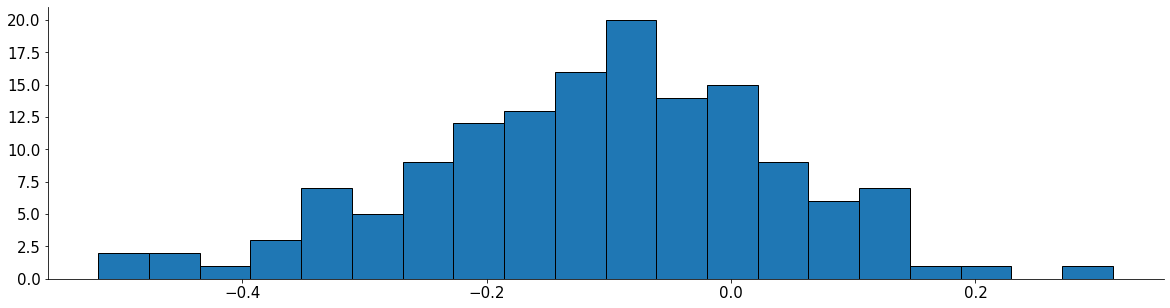

In [ ]:
plt.hist(coefficients, edgecolor = "black", bins = 20)
plt.show()

As it can be seen the the center of the distributin is near -0.1 which means a very weak inverse correlation between spike count and response time.

Before computing noise correlation it would be better to select those neurons that fire spikes more than a crtain level because firing rate can affect noise correlaton.

In [ ]:
high_spk_idx = np.mean(spike_counts,1) > 10     # Selecting neurons with high spike counts


high_spike_counts = spike_counts[high_spk_idx,:]
high_spike_counts.shape

(14, 340)

Now lets compute noise correlation between two example neurons.

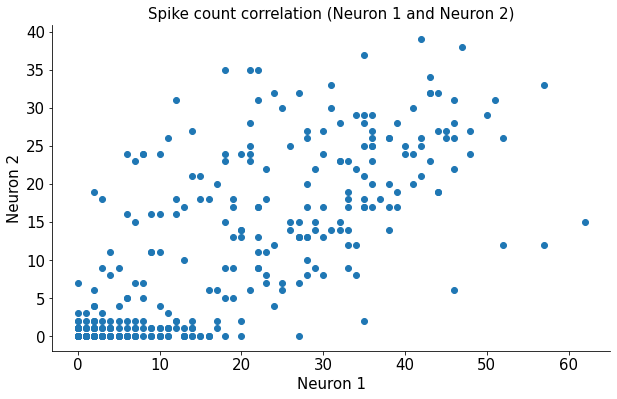

In [ ]:
N1  = high_spike_counts[1,:]
N2  = high_spike_counts[2,:]

corr_N1N2 = np.corrcoef(N1,N2)


fig,ax = plt.subplots(figsize = (10,6))
ax.scatter(N1,N2)
ax.set_xlabel('Neuron 1', size = 15)
ax.set_ylabel('Neuron 2', size = 15)
ax.set_title('Spike count correlation (Neuron 1 and Neuron 2)',size = 15)
plt.show()



Computing noise correlation between all pairs of neurons in visual regions



In [ ]:
rsc = np.corrcoef(high_spike_counts)    # Each row is variable

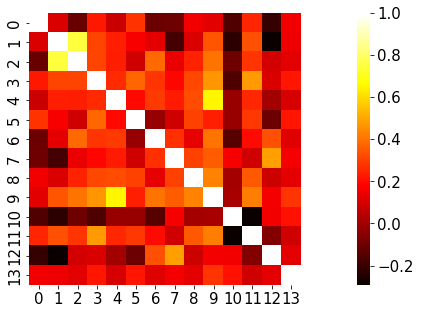

In [ ]:
sns.heatmap(rsc, cmap ='hot',square = True)
plt.show()

## **Irrigularity of inter-spike-interval (ISI)**

One important aspect of spiking variability is temporal distance between inidividual spikes during a trial. Some times neurons fires a burst of spikes (several spikes with short intervals between them) and some times they fire in more sparse manner. To capture temporal structure of spikes we extract inter-spike-interval.
<br>
<p align='center'>
<img src = 'https://github.com/MiladQolami/Neural-Data-Analysis/blob/main/images/inter%20spike%20interval.jpg?raw=1' width = '700'>

In [ ]:
# @markdown Data loading

!git clone https://github.com/MiladQolami/Neural-Data-Analysis
data = sio.loadmat('/content/Neural-Data-Analysis/SpikingVariablity/20080628_R7.mat')


This dataset contians single-unit responses of retinal gangelion cells in mouse in response to flashing light spots [Lefebvre JL et.al 2008]('https://crcns.org/data-sets/retina/ret-1/about-ret-1'). Here we have uploaded an example session containing spikes from 14 retinal neurons. Duration of this session is around 25 minutes and we have spike times for the whole duration, so this dataset is ideal for analyzing ISI distributin which we usually need to record neurons for quite long durations.

Spike times have been stored in `data['spikes']`. Because each neuron fires different number of spikes we put neurons ISIs in seperate lists.

In [3]:
ISIs = []    # Initiate an empty list for spike times   
for i in range(14):       # Loop over neurons and seperate spike times
  spike_time_i = (data['spikes'][i][0] ).flatten()
  ISI_i = np.diff(spike_time_i)
  ISIs.append(ISI_i)



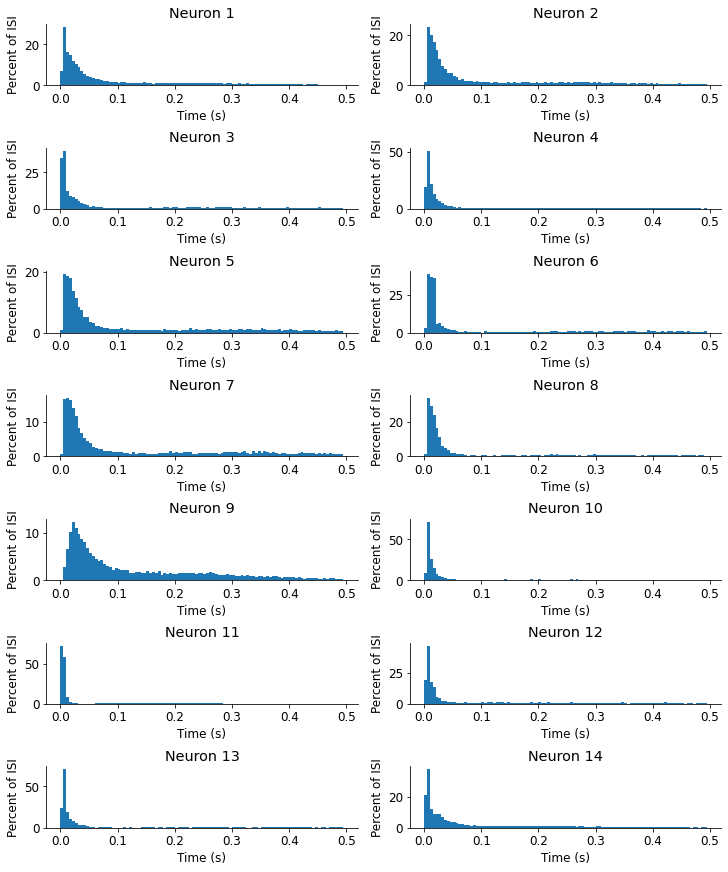

In [22]:
time_bins = np.arange(start = 0,stop = .5,step = .005,)     # Defining time bins for ISI distributions, here we chose 5 ms bins. Try different time bins to see the difference
fig, axs = plt.subplots(7, 2, figsize=(10, 12),constrained_layout=True)
axs = axs.ravel()
for i in range(14):
  axs[i].hist(ISIs[i],time_bins,density =True)
  axs[i].set_title(f'Neuron {i+1}')
  plt.setp(axs,ylabel = 'Percent of ISI',xlabel = 'Time (s)')


As you can see ISI distributions show quite significant variabilities between neurons. There are several techniques for measuring ISI variability and describing ISI distribution. Probably the simplest one is coefficient of variation:  $Cv = σ/μ$, where $σ$ is standard deviation and and $μ$ is mean of ISIs.

To have a sense of magnitude of this measure notice that C<sub>v</sub> of standard normal distribution is exactly 1. Small irrigularity in spiking, means smaller C<sub>v</sub>. 

let's add C<sub>v</sub> to the previous plots.



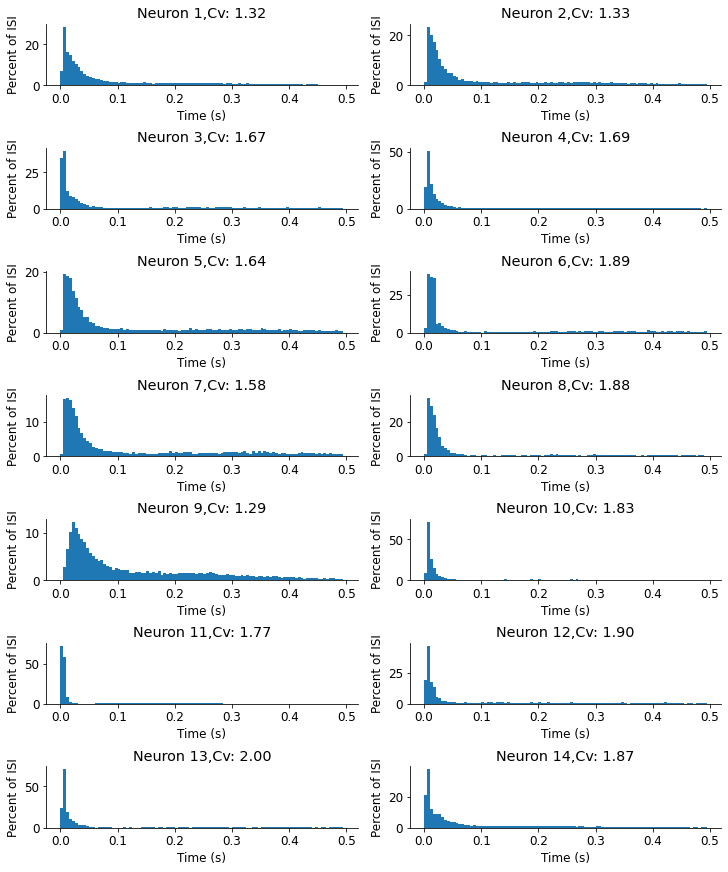

In [26]:
fig, axs = plt.subplots(7, 2, figsize=(10, 12),constrained_layout=True)
axs = axs.ravel()
for i in range(14):
  axs[i].hist(ISIs[i],time_bins,density =True)
  axs[i].set_title(f'Neuron {i+1},Cv: {np.std(ISIs[i])/np.mean(ISIs[i]):.2f}')
  plt.setp(axs,ylabel = 'Percent of ISI',xlabel = 'Time (s)')
plt.show()


## **Trial-to-tiral variablity**


<br>
<p align='center'>
<img src = 'https://github.com/MiladQolami/Neural-Data-Analysis/blob/main/images/spike%20correlation.jpg?raw=1' width = '700'>


#### **Basline Normalization**

If you record from a sensory neuron without presenting any stimulus, there still would be some neural activity. This activity at 'resting state' of a neuron is called baseline activity. Usually different neurons show different amount of basline activity.

To compare resposne of different neurons it is common to subtract baseline activity from the whole response durring a trial. This is called baseline normalization.

Here we have 500 ms of baseline activity before presentation of the stimulus. We take avrage during this period and subtract from the whole trial.

To do that we use a nice property of broadcasting in numpy arrays. In general in order to do elementwise operations with numpy arrays they should have the same size but we can also do operations in just one dimension of arrays. For example we can subtract mean of rows (first dimension) from all elements in the rows. This idea can be demonstrated as below:


<br>
<p align='center'>
<img src="https://github.com/MiladQolami/Neural-Data-Analysis/blob/main/images/Numpby%20array%20row%20subtraction.jpg?raw=0" width="700" height="300">


<


In [ ]:
spikes_vis_base_sub = spikes_vis[:,:,:] - np.mean(spikes_vis[:,:,0:50],2,keepdims=True)    # Baseline subtracted data


Let's plot the population response again. Note that the shape of the cureve should not change, just the scale on the y-axis.

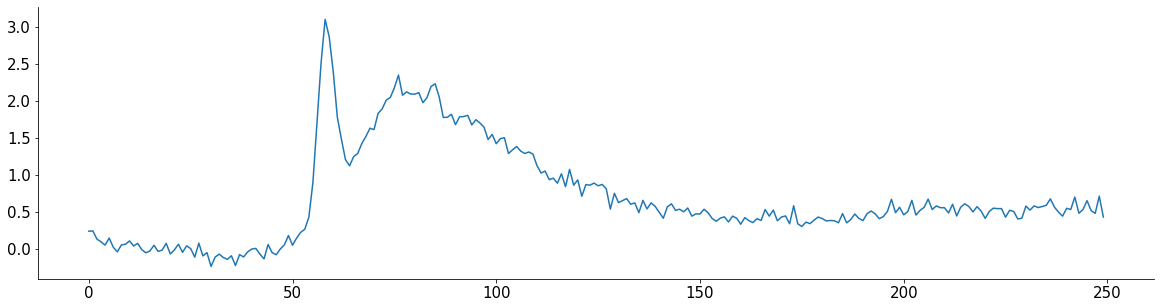

In [ ]:
average_resp_vis = np.mean(np.mean(spikes_vis_base_sub,0),0) * 100

fig,ax = plt.subplots()
ax.plot(time_bins,average_resp_vis)
plt.show()